<a href="https://colab.research.google.com/github/devanandini0210/zinc_detector/blob/main/EfficientDet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#unzipping the dataset
!unzip /content/drive/MyDrive/Master_Thesis/dataset.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/images/train/composited_0763.jpg  
  inflating: /content/__MACOSX/dataset/images/train/._composited_0763.jpg  
  inflating: /content/dataset/images/train/composited_0005.jpg  
  inflating: /content/__MACOSX/dataset/images/train/._composited_0005.jpg  
  inflating: /content/dataset/images/train/composited_0474_aug.jpg  
  inflating: /content/__MACOSX/dataset/images/train/._composited_0474_aug.jpg  
  inflating: /content/dataset/images/train/composited_0788.jpg  
  inflating: /content/__MACOSX/dataset/images/train/._composited_0788.jpg  
  inflating: /content/dataset/images/train/composited_0950.jpg  
  inflating: /content/__MACOSX/dataset/images/train/._composited_0950.jpg  
  inflating: /content/dataset/images/train/composited_0464_aug.jpg  
  inflating: /content/__MACOSX/dataset/images/train/._composited_0464_aug.jpg  
  inflating: /content/dataset/images/train/composited_0221_aug.jpg  
  inflating: /cont

In [ ]:
#installing the required packages
!pip install -q effdet albumentations pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#imports
import os
import glob
import torch
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet
from torchvision import transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

In [ ]:
#initialising the dataset Paths
DATA_DIR = '/content/dataset'
IMAGE_DIR = os.path.join(DATA_DIR, 'images')
LABEL_DIR = os.path.join(DATA_DIR, 'labels')
CLASSES = ['zinc']

In [ ]:
class YOLODataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_paths = sorted(glob.glob(f"{image_dir}/*.jpg"))
        self.label_paths = sorted(glob.glob(f"{label_dir}/*.txt"))
        self.transform = transform


    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape

        boxes = []
        labels = []

        with open(label_path, 'r') as f:
            for line in f:
                cls, cx, cy, bw, bh = map(float, line.strip().split())
                x1 = max(0, (cx - bw / 2) * w)
                y1 = max(0, (cy - bh / 2) * h)
                x2 = min(w, (cx + bw / 2) * w)
                y2 = min(h, (cy + bh / 2) * h)

                boxes.append([x1, y1, x2, y2])
                labels.append(int(cls) + 1)

        if len(boxes) == 0:
            return self.__getitem__((idx + 1) % len(self))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'img_scale': 1.0,
            'img_size': (h, w)
        }

        if self.transform:
            transformed = self.transform(
                image=image,
                bboxes=target['boxes'].tolist(),
                labels=target['labels'].tolist()
            )
            image = transformed['image']  # Already a tensor if ToTensorV2 is used
            target['boxes'] = torch.tensor(transformed['bboxes'], dtype=torch.float32)
            target['labels'] = torch.tensor(transformed['labels'], dtype=torch.int64)
        else:
            image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0  # Only apply if no transform

        return image, target


    def __len__(self):
        return len(self.image_paths)

In [ ]:
#resizing to 512x512
transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))


In [ ]:
def collate_fn_efficientdet(batch):
    images, targets = list(zip(*batch))
    images = torch.stack(images)

    boxes = [t["boxes"] for t in targets]
    classes = [t["labels"] for t in targets]
    img_scales = [t["img_scale"] for t in targets]
    img_sizes = [t["img_size"] for t in targets]

    return images, {
        "bbox": boxes,
        "cls": classes,
        "img_scale": torch.tensor(img_scales, dtype=torch.float32),
        "img_size": torch.tensor(img_sizes, dtype=torch.float32)
    }

In [ ]:
#loading the dataset
train_dataset = YOLODataset(os.path.join(IMAGE_DIR, 'train'), os.path.join(LABEL_DIR, 'train'), transform)
val_dataset = YOLODataset(os.path.join(IMAGE_DIR, 'val'), os.path.join(LABEL_DIR, 'val'), transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn_efficientdet)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn_efficientdet)

In [ ]:
#defining the model
def create_model(num_classes):
    config = get_efficientdet_config('tf_efficientdet_d0')
    config.num_classes = num_classes
    config.image_size = (512, 512)
    model = EfficientDet(config, pretrained_backbone=True)
    model.class_net = HeadNet(config, num_outputs=num_classes)
    return DetBenchTrain(model, config)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model(num_classes=len(CLASSES) + 1)  # +1 for background
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

DetBenchTrain(
  (model): EfficientDet(
    (backbone): EfficientNetFeatures(
      (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): SiLU(inplace=True)
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))

In [ ]:
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
best_loss = float('inf')
best_model_path = "/content/best_efficientdet.pth"


def train_one_epoch(epoch):
    model.train()
    total_loss = 0
    for images, targets in tqdm(train_loader, desc=f"Training Epoch {epoch}"):
        images = images.to(device)
        targets = {k: v.to(device) if torch.is_tensor(v) else [x.to(device) for x in v] for k, v in targets.items()}

        loss_dict = model(images, targets)
        loss = loss_dict['loss']

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch} Training Loss: {avg_loss:.4f}")
    return avg_loss


def validate_one_epoch(epoch):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc=f"Validation Epoch {epoch}"):
            images = images.to(device)
            targets = {k: v.to(device) if torch.is_tensor(v) else [x.to(device) for x in v] for k, v in targets.items()}

            loss_dict = model(images, targets)
            loss = loss_dict['loss']
            total_loss += loss.item()

    avg_loss = total_loss / len(val_loader)
    print(f"Epoch {epoch} Validation Loss: {avg_loss:.4f}")
    return avg_loss

#training the model and validating
for epoch in range(10):
    train_one_epoch(epoch)
    val_loss = validate_one_epoch(epoch)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved the new best model at epoch {epoch} with validation loss {best_loss:.4f}")


Training Epoch 0: 100%|██████████| 405/405 [01:29<00:00,  4.52it/s]


Epoch 0 Training Loss: 260.6620


Validation Epoch 0: 100%|██████████| 51/51 [00:07<00:00,  6.61it/s]


Epoch 0 Validation Loss: 124.9113
Saved the new best model at epoch 0 with validation loss 124.9113


Training Epoch 1: 100%|██████████| 405/405 [01:28<00:00,  4.59it/s]


Epoch 1 Training Loss: 64.9452


Validation Epoch 1: 100%|██████████| 51/51 [00:05<00:00,  9.13it/s]


Epoch 1 Validation Loss: 23.9802
Saved the new best model at epoch 1 with validation loss 23.9802


Training Epoch 2: 100%|██████████| 405/405 [01:28<00:00,  4.58it/s]


Epoch 2 Training Loss: 14.8474


Validation Epoch 2: 100%|██████████| 51/51 [00:05<00:00,  9.22it/s]


Epoch 2 Validation Loss: 8.0246
Saved the new best model at epoch 2 with validation loss 8.0246


Training Epoch 3: 100%|██████████| 405/405 [01:28<00:00,  4.58it/s]


Epoch 3 Training Loss: 5.8830


Validation Epoch 3: 100%|██████████| 51/51 [00:06<00:00,  8.14it/s]


Epoch 3 Validation Loss: 4.1703
Saved the new best model at epoch 3 with validation loss 4.1703


Training Epoch 4: 100%|██████████| 405/405 [01:27<00:00,  4.63it/s]


Epoch 4 Training Loss: 3.3880


Validation Epoch 4: 100%|██████████| 51/51 [00:06<00:00,  7.82it/s]


Epoch 4 Validation Loss: 2.7930
Saved the new best model at epoch 4 with validation loss 2.7930


Training Epoch 5: 100%|██████████| 405/405 [01:27<00:00,  4.62it/s]


Epoch 5 Training Loss: 2.3732


Validation Epoch 5: 100%|██████████| 51/51 [00:06<00:00,  8.28it/s]


Epoch 5 Validation Loss: 2.1721
Saved the new best model at epoch 5 with validation loss 2.1721


Training Epoch 6: 100%|██████████| 405/405 [01:27<00:00,  4.60it/s]


Epoch 6 Training Loss: 1.9590


Validation Epoch 6: 100%|██████████| 51/51 [00:05<00:00,  9.12it/s]


Epoch 6 Validation Loss: 1.8692
Saved the new best model at epoch 6 with validation loss 1.8692


Training Epoch 7: 100%|██████████| 405/405 [01:27<00:00,  4.63it/s]


Epoch 7 Training Loss: 1.7207


Validation Epoch 7: 100%|██████████| 51/51 [00:05<00:00,  9.18it/s]


Epoch 7 Validation Loss: 1.6575
Saved the new best model at epoch 7 with validation loss 1.6575


Training Epoch 8: 100%|██████████| 405/405 [01:28<00:00,  4.57it/s]


Epoch 8 Training Loss: 1.5817


Validation Epoch 8: 100%|██████████| 51/51 [00:06<00:00,  8.25it/s]


Epoch 8 Validation Loss: 1.5500
Saved the new best model at epoch 8 with validation loss 1.5500


Training Epoch 9: 100%|██████████| 405/405 [01:27<00:00,  4.64it/s]


Epoch 9 Training Loss: 1.4855


Validation Epoch 9: 100%|██████████| 51/51 [00:06<00:00,  7.82it/s]


Epoch 9 Validation Loss: 1.4707
Saved the new best model at epoch 9 with validation loss 1.4707


In [ ]:
#creating the test set and loader
test_dataset = YOLODataset(os.path.join(IMAGE_DIR, 'test'), os.path.join(LABEL_DIR, 'test'), transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn_efficientdet)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving best_efficientdet.pth to best_efficientdet.pth


In [ ]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchPredict
from effdet.efficientdet import HeadNet
#loading the saved model
def load_model_from_local(num_classes, path):
    config = get_efficientdet_config('tf_efficientdet_d0')
    config.num_classes = num_classes
    config.image_size = (512, 512)

    model = EfficientDet(config, pretrained_backbone=False)
    model.class_net = HeadNet(config, num_outputs=num_classes)

    bench = DetBenchPredict(model)

    checkpoint = torch.load(path, map_location=device)
    bench.load_state_dict(checkpoint)

    bench.eval()
    bench.to(device)
    return bench

In [ ]:
number_classes = len(CLASSES) + 1
local_path = "/content/best_efficientdet.pth"
model = load_model_from_local(number_classes, local_path)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, average_precision_score
import time
import torchvision.ops as ops

#evaluating the model
def evaluate_model(model, dataloader, iou_threshold=0.5):
    all_preds = []
    all_gts = []
    all_scores = []
    all_labels = []
    total_inference_time = 0
    total_images = 0

    model.eval()

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            batch_size = images.size(0)

            start = time.time()
            outputs = model(images)
            end = time.time()

            total_inference_time += end - start
            total_images += batch_size

            for i in range(batch_size):
                out = outputs[i]
                boxes = out[:, :4].cpu()
                scores = out[:, 4].cpu()
                labels = out[:, 5].cpu()

                gt_boxes = targets['bbox'][i].cpu()
                gt_labels = targets['cls'][i].cpu()

                all_preds.append((boxes, labels, scores))
                all_gts.append((gt_boxes, gt_labels))
                all_scores.extend(scores.numpy())
                all_labels.extend(labels.numpy())


    #calculating the metrics
    TP, FP, FN = 0, 0, 0
    precisions, recalls, f1s, aps = [], [], [], []

    for pred, gt in zip(all_preds, all_gts):
        pred_boxes, pred_labels, pred_scores = pred
        gt_boxes, gt_labels = gt

        if len(pred_boxes) == 0 and len(gt_boxes) == 0:
            continue

        if len(pred_boxes) > 0 and len(gt_boxes) > 0:
            ious = ops.box_iou(pred_boxes, gt_boxes)
            matched_pred = set()
            matched_gt = set()

            for i in range(ious.size(0)):
                for j in range(ious.size(1)):
                    if ious[i, j] >= iou_threshold and j not in matched_gt and i not in matched_pred:
                        TP += 1
                        matched_pred.add(i)
                        matched_gt.add(j)

            FP += len(pred_boxes) - len(matched_pred)
            FN += len(gt_boxes) - len(matched_gt)
        elif len(pred_boxes) > 0:
            FP += len(pred_boxes)
        elif len(gt_boxes) > 0:
            FN += len(gt_boxes)

    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
    fps = total_images / total_inference_time
    avg_inference_time = total_inference_time / total_images

    #calculating the model size and parameter count
    param_count = sum(p.numel() for p in model.parameters())
    model_size_mb = sum(p.element_size() * p.nelement() for p in model.parameters()) / (1024 ** 2)

    #printing the output
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"Inference Time per Image: {avg_inference_time:.4f} sec")
    print(f"FPS: {fps:.2f}")
    print(f"Model Size: {model_size_mb:.2f} MB")
    print(f"Total Parameters: {param_count:,}")

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "fps": fps,
        "inference_time": avg_inference_time,
        "model_size_mb": model_size_mb,
        "param_count": param_count
    }, all_preds, all_gts

results, all_preds, all_gts = evaluate_model(model, test_loader)

Evaluating: 100%|██████████| 204/204 [00:10<00:00, 19.28it/s]


Precision: 0.0003
Recall:    0.0052
F1-Score:  0.0006
Inference Time per Image: 0.0357 sec
FPS: 28.02
Model Size: 14.60 MB
Total Parameters: 3,828,587


In [ ]:
def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(x2 - x1, 0) * max(y2 - y1, 0)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area
    if union_area == 0:
        return 0.0
    return inter_area / union_area

In [ ]:
from collections import defaultdict

def compute_map_ap(preds, gts, iou_threshold=0.5, num_classes=2):
    aps = []

    for cls in range(1, num_classes):
        cls_preds = []
        cls_gts = defaultdict(list)


        for i, (pred, gt) in enumerate(zip(preds, gts)):
            p_boxes, p_labels, p_scores = pred
            g_boxes, g_labels = gt

            for j in range(len(g_labels)):
                if g_labels[j] == cls:
                    cls_gts[i].append(g_boxes[j].tolist())

            for j in range(len(p_labels)):
                if p_labels[j] == cls:
                    cls_preds.append({
                        'image_id': i,
                        'box': p_boxes[j].tolist(),
                        'score': p_scores[j].item(),
                        'matched': False
                    })

        cls_preds = sorted(cls_preds, key=lambda x: x['score'], reverse=True)

        tp = np.zeros(len(cls_preds))
        fp = np.zeros(len(cls_preds))
        total_gts = sum(len(boxes) for boxes in cls_gts.values())

        for i, pred in enumerate(cls_preds):
            gt_boxes = cls_gts[pred['image_id']]
            ious = [compute_iou(pred['box'], gt) for gt in gt_boxes]
            max_iou = max(ious) if ious else 0

            if max_iou >= iou_threshold and gt_boxes:
                match_idx = np.argmax(ious)
                del gt_boxes[match_idx]
                tp[i] = 1
            else:
                fp[i] = 1

        cum_tp = np.cumsum(tp)
        cum_fp = np.cumsum(fp)
        recalls = cum_tp / (total_gts + 1e-6)
        precisions = cum_tp / (cum_tp + cum_fp + 1e-6)

        ap = 0.0
        for t in np.linspace(0, 1, 11):
            p = precisions[recalls >= t].max() if np.any(recalls >= t) else 0
            ap += p / 11.0

        aps.append(ap)
        print(f"AP for class {cls}: {ap:.4f}")

    map_score = np.mean(aps) if aps else 0.0
    print(f"\nMean Average Precision (mAP): {map_score:.4f}")
    return aps, map_score

In [ ]:
aps, map_score = compute_map_ap(all_preds, all_gts, iou_threshold=0.5, num_classes=len(CLASSES)+1)

AP for class 1: 0.0000

Mean Average Precision (mAP): 0.0000


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, confusion_matrix
import numpy as np
import torch
import torchvision.ops as ops

In [ ]:
def plot_pr_conf_iou(all_preds, all_gts, iou_threshold=0.5):
    all_scores = []
    all_true = []
    all_pred = []
    all_ious = []

    for pred, gt in zip(all_preds, all_gts):
        p_boxes, p_labels, p_scores = pred
        g_boxes, g_labels = gt

        if len(p_boxes) > 0 and len(g_boxes) > 0:
            ious = ops.box_iou(p_boxes, g_boxes)
            for i in range(ious.shape[0]):
                max_iou = torch.max(ious[i]).item()
                all_ious.append(max_iou)
                matched = max_iou >= iou_threshold
                all_scores.append(p_scores[i].item())
                all_true.append(1 if matched else 0)
                all_pred.append(1)
        elif len(p_boxes) > 0:
            for i in range(len(p_boxes)):
                all_scores.append(p_scores[i].item())
                all_true.append(0)
                all_pred.append(1)

    #PR Curve
    precision, recall, _ = precision_recall_curve(all_true, all_scores)
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision Recall Curve")
    plt.grid()
    plt.show()

    #Confidence Histogram
    plt.figure(figsize=(6, 4))
    sns.histplot(all_scores, bins=20, kde=False)
    plt.title("Confidence Score Histogram")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.show()

    #IoU Histogram
    if all_ious:
        plt.figure(figsize=(6, 4))
        sns.histplot(all_ious, bins=20, kde=False)
        plt.title("IoU Histogram")
        plt.xlabel("IoU")
        plt.ylabel("Frequency")
        plt.show()

In [ ]:
#Confusion Matrix
def plot_normalised_conf_matrix(all_preds, all_gts, num_classes):
    y_true = []
    y_pred = []

    for pred, gt in zip(all_preds, all_gts):
        p_boxes, p_labels, _ = pred
        g_boxes, g_labels = gt

        if len(p_boxes) > 0 and len(g_boxes) > 0:
            ious = ops.box_iou(p_boxes, g_boxes)
            for i in range(ious.size(0)):
                max_iou, idx = torch.max(ious[i], dim=0)
                if max_iou >= 0.5:
                    y_true.append(g_labels[idx].item())
                    y_pred.append(p_labels[i].item())
        for g in g_labels:
            y_true.append(g.item())
            y_pred.append(0)

    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)), normalize='true')

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Normalised Confusion Matrix")
    plt.show()

In [ ]:
#FP and FN Heatmaps
def plot_fp_fn_heatmaps(all_preds, all_gts, image_shape=(512, 512)):
    fp_heatmap = np.zeros(image_shape)
    fn_heatmap = np.zeros(image_shape)

    for pred, gt in zip(all_preds, all_gts):
        p_boxes, p_labels, _ = pred
        g_boxes, g_labels = gt

        matched_gt = set()
        if len(p_boxes) > 0 and len(g_boxes) > 0:
            ious = ops.box_iou(p_boxes, g_boxes)

            for i in range(len(p_boxes)):
                max_iou, idx = torch.max(ious[i], dim=0)
                if max_iou < 0.5:
                    # False Positive
                    box = p_boxes[i].numpy().astype(int)
                    x1, y1, x2, y2 = box
                    fp_heatmap[y1:y2, x1:x2] += 1
                else:
                    matched_gt.add(idx.item())

            for j in range(len(g_boxes)):
                if j not in matched_gt:
                    # False Negative
                    box = g_boxes[j].numpy().astype(int)
                    x1, y1, x2, y2 = box
                    fn_heatmap[y1:y2, x1:x2] += 1

    fp_heatmap = fp_heatmap / (fp_heatmap.max() + 1e-6)
    fn_heatmap = fn_heatmap / (fn_heatmap.max() + 1e-6)

    plt.figure(figsize=(6, 5))
    sns.heatmap(fp_heatmap, cmap="Reds")
    plt.title("False Positive Heatmap")
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(6, 5))
    sns.heatmap(fn_heatmap, cmap="Purples")
    plt.title("False Negative Heatmap")
    plt.axis('off')
    plt.show()

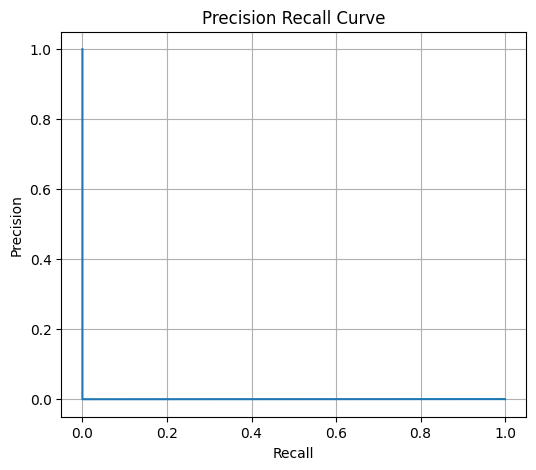

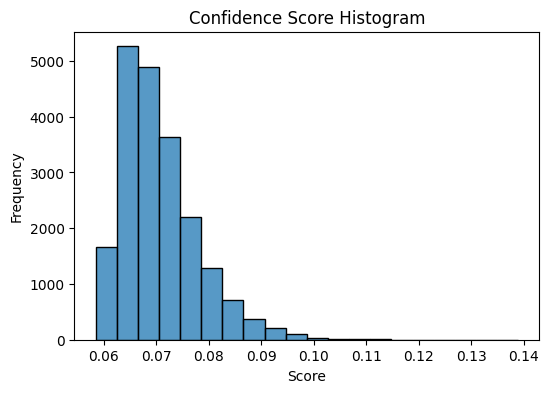

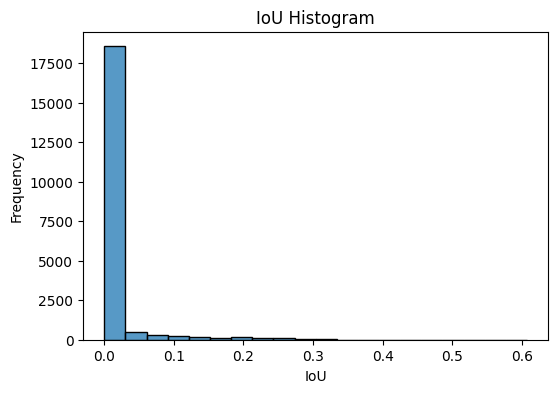

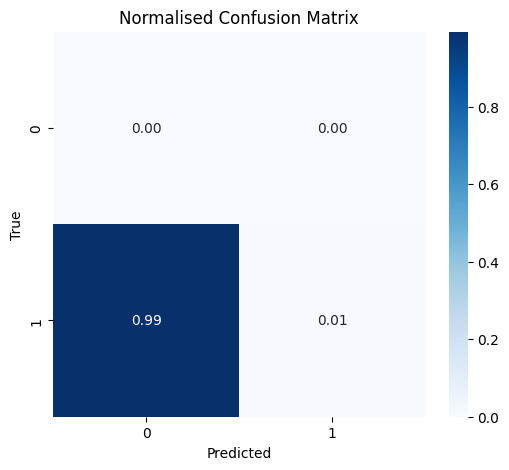

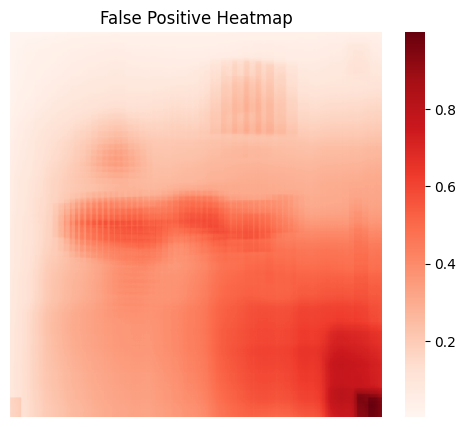

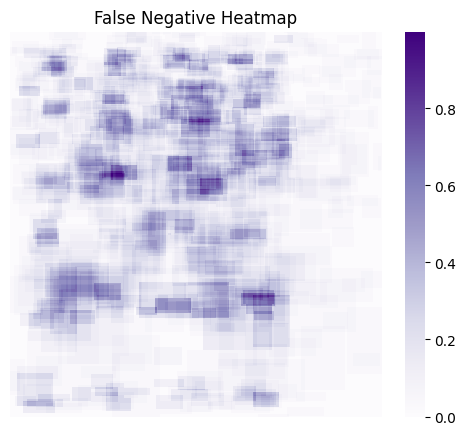

In [ ]:
plot_pr_conf_iou(all_preds, all_gts, iou_threshold=0.5)
plot_normalised_conf_matrix(all_preds, all_gts, num_classes=len(CLASSES)+1)
plot_fp_fn_heatmaps(all_preds, all_gts, image_shape=(512, 512))

In [ ]:
def unnormalize(image_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return image_tensor * std + mean

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

def visualize_prediction(image_tensor, pred_boxes, pred_scores, pred_labels, gt_boxes, gt_labels, score_threshold=0.2):
    image = unnormalize(image_tensor).permute(1, 2, 0).cpu().numpy()
    image = np.clip(image, 0, 1)

    image = (image * 255).astype(np.uint8)

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)

    #drawing the ground truth boxes in green
    for box, label in zip(gt_boxes, gt_labels):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, f"GT {label}", color='lime', fontsize=10, weight='bold')

    #drawing the predicted boxes in red
    for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
        if score < score_threshold:
            continue
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, f"P {label} {score:.2f}", color='red', fontsize=10, weight='bold')

    plt.title("Green: Ground Truth | Red: Prediction")
    plt.axis('off')
    plt.show()

Sample 120


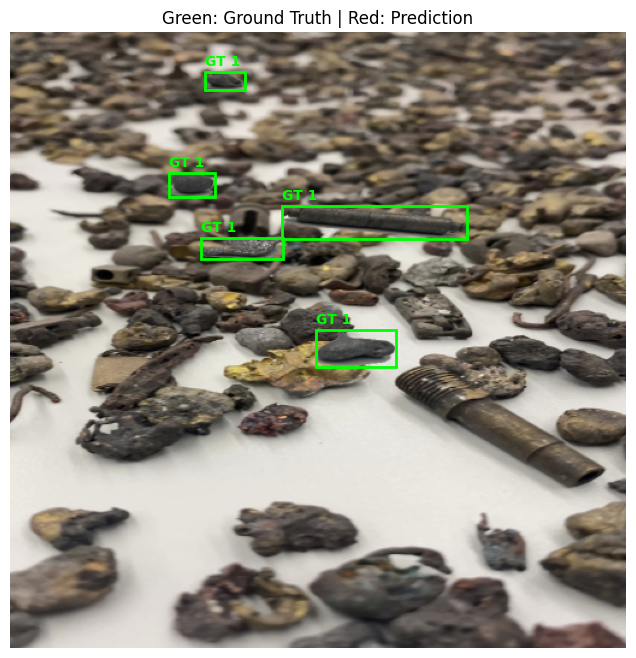

Sample 38


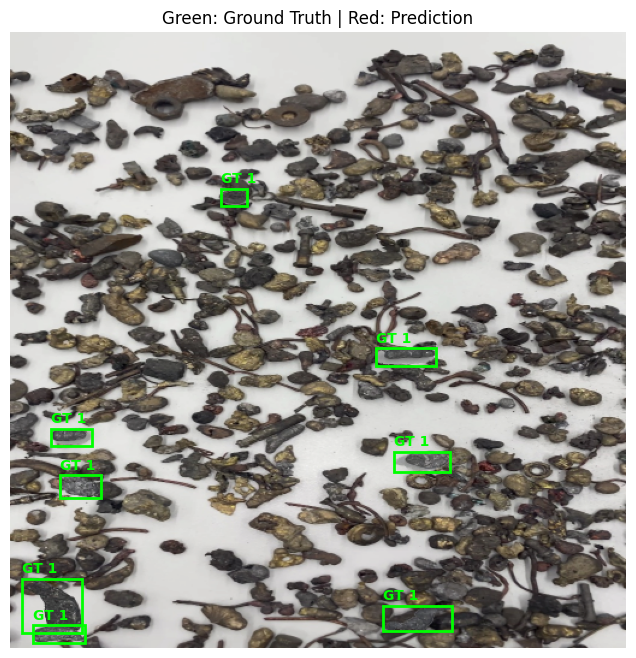

Sample 40


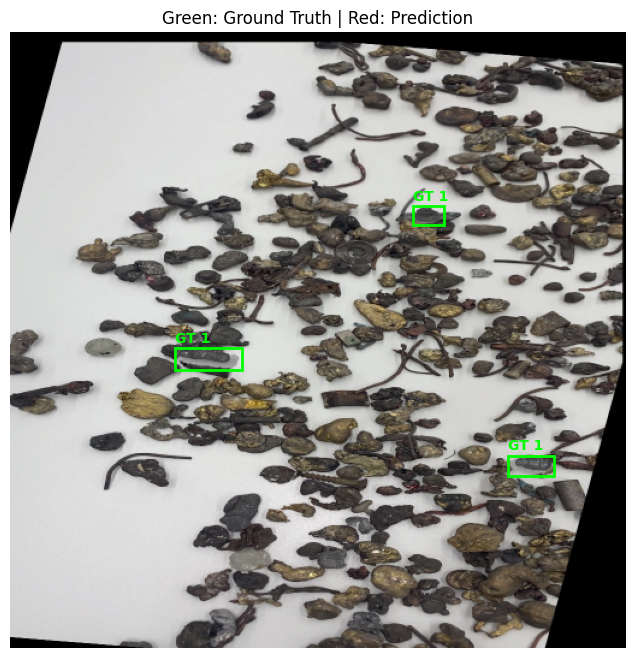

In [ ]:
for idx in random.sample(range(len(test_dataset)), 3):
    image, target = test_dataset[idx]
    image_input = image.unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(image_input)[0].cpu()

    pred_boxes = out[:, :4]
    pred_scores = out[:, 4]
    pred_labels = out[:, 5]

    gt_boxes = target['boxes']
    gt_labels = target['labels']

    print(f"Sample {idx}")
    visualize_prediction(image, pred_boxes, pred_scores, pred_labels, gt_boxes, gt_labels)